In [24]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt

from rdkit import Chem
from rdkit.Chem import AllChem, Draw 


from PIL import Image, ExifTags
from matplotlib import cm

import h5py
from IPython.display import display

import torch 
from torch.utils.data import TensorDataset, DataLoader

from datasets import load_dataset
import datasets 
from datasets import Dataset

from transformers import ViTImageProcessor

(300, 300, 3)
<class 'list'>


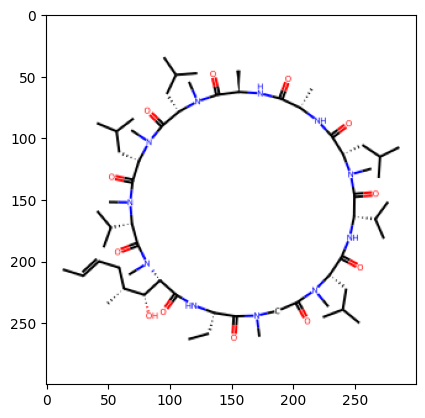

-6.6
<PIL.Image.Image image mode=RGB size=300x300 at 0x31671BD10> (14668,)


In [25]:
# Load the data from the h5py file
h5file = '../../../docs/data/Augmented_PepNet_data.h5'

with h5py.File(h5file, 'r') as F:
    #print(type(F['images'][0]))
    images = np.array(F['images'])
    images = np.clip(images, 0, 255).astype(np.uint8)
    print(images[0].shape)
    #images = [Image.fromarray(img, 'RGB') for img in images]
    images = [Image.fromarray(img) for img in images]
    #images = [Image.fromarray((img * 255).astype(np.uint8) for img in images)]
    print(type(images))
    
    labels = np.array(F['permeability'])
    #labels = np.array([10**label for label in labels])

#Verify the data
plt.imshow(images[0])
plt.show()

#print(images[0])
print(labels[0])

data = images 

# we change the data type and permute the color channel axis from place 3 to 1, to conform with pytorch defaults.
#data = data.type(torch.float32).permute(0,3,1,2)  # leave this as is
# labels = labels.astype(torch.LongTensor)            # leave this as is
print(data[0], labels.shape)

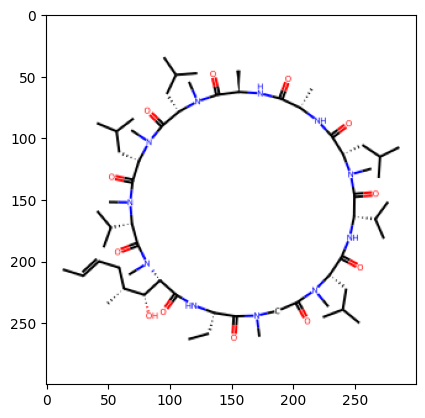

In [26]:
#Check if we can recontruct the image
img_array = np.array(images[0])
plt.imshow(img_array)

In [27]:
# Split sizes
train_size = 12000
val_size = 2668
test_size = 1000

#train_size = 20
#val_size = 10
#test_size = 20

# Randomly shuffle the data
np.random.shuffle(data)

# Split the data
train_data = data[:train_size]
val_data = data[train_size:train_size+val_size]
test_data = data[train_size+val_size:train_size+val_size+test_size]

train_labels = labels[:train_size]
val_labels = labels[train_size:train_size+val_size]
test_labels = labels[train_size+val_size:train_size+val_size+test_size]

train_dict = {"img": train_data, "label": train_labels}
val_dict = {"img": val_data, "label": val_labels}
test_dict = {"img": test_data, "label": test_labels}

train_dataset = datasets.Dataset.from_dict(train_dict)#.cast_column("img", Image())
val_dataset = datasets.Dataset.from_dict(val_dict)#.cast_column("img", Image())
test_dataset = datasets.Dataset.from_dict(test_dict)#.cast_column("img", Image())

print(type(train_dataset), type(val_dataset), type(test_dataset))


<class 'datasets.arrow_dataset.Dataset'> <class 'datasets.arrow_dataset.Dataset'> <class 'datasets.arrow_dataset.Dataset'>


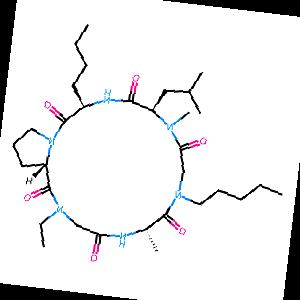

In [28]:
train_dataset[0]['img']


In [29]:
train_dataset[0]['label']

-6.6

####################################### Preprocessing the Data #######################################

In [30]:
from transformers import ViTImageProcessor

processor = ViTImageProcessor.from_pretrained("google/vit-base-patch16-224-in21k")

/Users/ziadelmalki/anaconda3/envs/pepnet/lib/python3.12/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [31]:
from torchvision.transforms import (CenterCrop, 
                                    Compose, 
                                    Normalize, 
                                    RandomHorizontalFlip,
                                    RandomResizedCrop, 
                                    Resize, 
                                    ToTensor)

image_mean, image_std = processor.image_mean, processor.image_std
size = processor.size["height"]

normalize = Normalize(mean=image_mean, std=image_std)
_train_transforms = Compose(
        [
            RandomResizedCrop(size),
            RandomHorizontalFlip(),
            ToTensor(),
            normalize,
        ]
    )

_val_transforms = Compose(
        [
            Resize(size),
            CenterCrop(size),
            ToTensor(),
            normalize,
        ]
    )

def train_transforms(examples):
    examples['pixel_values'] = [_train_transforms(image.convert("RGB")) for image in examples['img']]
    return examples

def val_transforms(examples):
    examples['pixel_values'] = [_val_transforms(image.convert("RGB")) for image in examples['img']]
    return examples

In [32]:
train_dataset.set_transform(train_transforms)
val_dataset.set_transform(val_transforms)
test_dataset.set_transform(val_transforms)

In [33]:
train_dataset[:2]

{'img': [<PIL.PngImagePlugin.PngImageFile image mode=RGB size=300x300>,
  <PIL.PngImagePlugin.PngImageFile image mode=RGB size=300x300>],
 'label': [-6.6, -6.6],
 'pixel_values': [tensor([[[1., 1., 1.,  ..., 1., 1., 1.],
           [1., 1., 1.,  ..., 1., 1., 1.],
           [1., 1., 1.,  ..., 1., 1., 1.],
           ...,
           [1., 1., 1.,  ..., 1., 1., 1.],
           [1., 1., 1.,  ..., 1., 1., 1.],
           [1., 1., 1.,  ..., 1., 1., 1.]],
  
          [[1., 1., 1.,  ..., 1., 1., 1.],
           [1., 1., 1.,  ..., 1., 1., 1.],
           [1., 1., 1.,  ..., 1., 1., 1.],
           ...,
           [1., 1., 1.,  ..., 1., 1., 1.],
           [1., 1., 1.,  ..., 1., 1., 1.],
           [1., 1., 1.,  ..., 1., 1., 1.]],
  
          [[1., 1., 1.,  ..., 1., 1., 1.],
           [1., 1., 1.,  ..., 1., 1., 1.],
           [1., 1., 1.,  ..., 1., 1., 1.],
           ...,
           [1., 1., 1.,  ..., 1., 1., 1.],
           [1., 1., 1.,  ..., 1., 1., 1.],
           [1., 1., 1.,  ..., 1., 1

In [34]:
train_dataset[0]['pixel_values'][2][60]

tensor([ 1.0000,  1.0000,  1.0000,  1.0000,  1.0000,  1.0000,  1.0000,  1.0000,
         1.0000,  1.0000,  1.0000,  1.0000,  1.0000,  1.0000,  1.0000,  1.0000,
         1.0000,  1.0000,  1.0000,  1.0000,  1.0000,  1.0000,  1.0000,  1.0000,
         1.0000,  1.0000,  1.0000,  1.0000,  1.0000,  1.0000,  1.0000,  1.0000,
         1.0000,  1.0000,  1.0000,  1.0000,  1.0000,  1.0000,  1.0000,  1.0000,
         1.0000,  1.0000,  1.0000,  1.0000,  1.0000,  1.0000,  1.0000,  1.0000,
         1.0000,  1.0000,  1.0000,  1.0000,  1.0000,  1.0000,  1.0000,  1.0000,
         1.0000,  1.0000,  1.0000,  1.0000,  1.0000,  1.0000,  1.0000,  1.0000,
         1.0000,  1.0000,  1.0000,  1.0000,  1.0000,  1.0000,  1.0000,  1.0000,
         1.0000,  0.6000, -0.9686, -0.3804,  0.7255,  1.0000,  1.0000,  1.0000,
         1.0000,  1.0000,  1.0000,  1.0000,  1.0000,  1.0000,  1.0000,  1.0000,
         1.0000,  1.0000,  1.0000,  1.0000,  1.0000,  1.0000,  1.0000,  1.0000,
         1.0000,  1.0000,  1.0000,  1.00

In [35]:
train_dataset.shape

(12000, 2)

In [36]:

def collate_fn(examples):
    pixel_values = torch.stack([example["pixel_values"] for example in examples])
    labels = torch.tensor([example["label"] for example in examples])
    return {"pixel_values": pixel_values, "labels": labels}

train_dataloader = DataLoader(train_dataset, collate_fn=collate_fn, batch_size=4)

In [37]:
batch = next(iter(train_dataloader))
for k,v in batch.items():
  if isinstance(v, torch.Tensor):
    print(k, v.shape)

pixel_values torch.Size([4, 3, 224, 224])
labels torch.Size([4])


#################################### Define the Model    ##############################################

In [38]:
#from transformers import ViTForImageClassification
#import torch.nn as nn

# Define your regression model based on ViT
#class ViTForRegression(ViTForImageClassification):
 #   def __init__(self, config):
  #      super().__init__(config)
        # Modify the output layer for regression
   #     self.classifier = nn.Linear(config.hidden_size, 1)  # Output a single value


#model = ViTForRegression.from_pretrained('google/vit-base-patch16-224-in21k',num_labels=1) #num_labels=1 to solve the target dimension mismatch with the input

In [39]:
from transformers import ViTForImageClassification
import torch.nn as nn

#model = ViTForImageClassification.from_pretrained('google/vit-base-patch16-224-in21k')

#model.config()
#model.base_model.config

In [40]:
from transformers import ViTForImageClassification
import torch.nn as nn

class ViTForRegression(ViTForImageClassification):
    def __init__(self, config):
        super().__init__(config)
        # Add additional layers before the final output layer
        self.additional_layers = nn.Sequential(
            nn.Linear(config.hidden_size, config.hidden_size),  # Add a linear layer
            nn.ReLU(),  # Add activation function
            nn.Linear(config.hidden_size, config.hidden_size)  # Add another linear layer
        )
        # Modify the output layer for regression
        self.classifier = nn.Linear(config.hidden_size, 1)  # Output a single value

# Load configuration
#config = ViTForRegression.from_pretrained('google/vit-base-patch16-224-in21k')
# Create model instance
model = ViTForRegression.from_pretrained('google/vit-base-patch16-224-in21k',num_labels=1) #num_labels=1 to solve the target dimension mismatch with the input
model.base_model.config

Some weights of ViTForRegression were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['additional_layers.0.bias', 'additional_layers.0.weight', 'additional_layers.2.bias', 'additional_layers.2.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ViTConfig {
  "_name_or_path": "google/vit-base-patch16-224-in21k",
  "architectures": [
    "ViTModel"
  ],
  "attention_probs_dropout_prob": 0.0,
  "encoder_stride": 16,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.0,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0"
  },
  "image_size": 224,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "LABEL_0": 0
  },
  "layer_norm_eps": 1e-12,
  "model_type": "vit",
  "num_attention_heads": 12,
  "num_channels": 3,
  "num_hidden_layers": 12,
  "patch_size": 16,
  "qkv_bias": true,
  "transformers_version": "4.40.1"
}

In [41]:
#model.enable_input_require_grads() # Enable gradients for the input

In [42]:
#Print the model and check its parameters (if layers are frozen or not)
#Normalize the labels 
#Check the distriubtion and see if it is normal othewise scale 
#Learning rate make it bigger 
#4 8 16 32 64


In [43]:
from transformers import TrainingArguments, Trainer

metric_name = "mean_squared_error"

args = TrainingArguments(
    f"PepNet_Model_2.0",
    save_strategy="epoch",
    evaluation_strategy="epoch",
    learning_rate=5e-4, #Used to be 2e-5, 0.001 too large 1e-3 1e-4 1e-5 
    per_device_train_batch_size=8, #Used to be 10
    per_device_eval_batch_size=4, #Used to be 4
    num_train_epochs=20, #Used to be 3
    weight_decay=0.01,
    load_best_model_at_end=True,
    metric_for_best_model=metric_name,
    logging_dir='logs',
    remove_unused_columns=False,
)

In [44]:
#Maybe crop the predictions and labels so that the accuracy is correct when we are within a certain range of the true value

from sklearn.metrics import mean_squared_error, accuracy_score
import numpy as np

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    #predictions = np.argmax(predictions, axis=1)
    return dict(mean_squared_error=mean_squared_error(predictions, labels))
    #return dict(accuracy=accuracy_score(predictions, labels))



In [45]:

trainer = Trainer(
    model,
    args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    data_collator=collate_fn,
    compute_metrics=compute_metrics,
    tokenizer=processor,
)

######################################## Train the Model ######################################

# Start tensorboard.
!load_ext tensorboard
!tensorboard --logdir logs/

In [46]:
trainer.train()

  0%|          | 0/30000 [00:00<?, ?it/s]

{'loss': 1.6371, 'grad_norm': 0.05492919310927391, 'learning_rate': 0.0004916666666666666, 'epoch': 0.33}


KeyboardInterrupt: 

###################################### Evaluate the Model ################################################

In [ ]:
outputs = trainer.predict(test_dataset)
#print(outputs)

  0%|          | 0/250 [00:00<?, ?it/s]

In [ ]:
print(outputs.metrics)

{'test_loss': 3.5656216144561768, 'test_mean_squared_error': 3.5656216144561768, 'test_runtime': 34.9976, 'test_samples_per_second': 28.573, 'test_steps_per_second': 7.143}


In [ ]:
print(outputs.predictions.shape)

(1000, 1)


In [ ]:
print(outputs)

PredictionOutput(predictions=array([[-4.214377 ],
       [-4.2119703],
       [-4.2141013],
       [-4.2147856],
       [-4.2146487],
       [-4.210804 ],
       [-4.2133484],
       [-4.212805 ],
       [-4.214485 ],
       [-4.2125945],
       [-4.2134457],
       [-4.2132998],
       [-4.21302  ],
       [-4.2124925],
       [-4.2134414],
       [-4.213201 ],
       [-4.212281 ],
       [-4.2144046],
       [-4.2145734],
       [-4.213728 ],
       [-4.2129893],
       [-4.214331 ],
       [-4.2138977],
       [-4.2116013],
       [-4.209425 ],
       [-4.2108817],
       [-4.212504 ],
       [-4.215012 ],
       [-4.2122383],
       [-4.2124877],
       [-4.2117724],
       [-4.2146497],
       [-4.212858 ],
       [-4.213956 ],
       [-4.215034 ],
       [-4.2125463],
       [-4.2138023],
       [-4.2129087],
       [-4.212917 ],
       [-4.2128015],
       [-4.211825 ],
       [-4.212363 ],
       [-4.212875 ],
       [-4.2141542],
       [-4.213999 ],
       [-4.2132325],
     

In [ ]:
#l=np.expand_dims(, axis=0)
l=np.squeeze(outputs.predictions)
logP_pred = [np.log10(x) for x in l]
print(logP_pred)

[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,

/var/folders/fq/z8xzcty574l8c89175k4sxxw0000gn/T/ipykernel_2375/3801068422.py:3: RuntimeWarning: invalid value encountered in log10
  logP_pred = [np.log10(x) for x in l]


In [ ]:
log_labels = [np.log10(x) for x in outputs.label_ids]
print(log_labels[9])

nan


/var/folders/fq/z8xzcty574l8c89175k4sxxw0000gn/T/ipykernel_2375/1716613474.py:1: RuntimeWarning: invalid value encountered in log10
  log_labels = [np.log10(x) for x in outputs.label_ids]


In [ ]:
#Check the variance in the embbeding layer, if not enough variance, we need to train the backbone of the model as well 

In [ ]:
import torch

# Define a function to calculate the variance of embeddings
def calculate_embedding_variance(model, data_loader, device):
    # Put the model and its parameters in evaluation mode and move them to the specified device
    model = model.eval().to(device)
    
    # Lists to store embeddings
    embeddings = []
    
    # Iterate over the data loader
    with torch.no_grad():
        for batch in data_loader:
            # Extract pixel values from batch and move them to the specified device
            pixel_values = batch['pixel_values'].to(device)
            
            # Forward pass through the model to get model outputs
            outputs = model(pixel_values)
            
            # Get embeddings from the output
            # Assuming you're using ViTForImageClassification
            #embedding = outputs.last_hidden_state  # Assuming embeddings are from the last_hidden_state
            embedding = nn.Embedding.from_pretrained(F['permeability'])
            # Note: You may need to adjust this depending on the specific output structure of your model
            
            # Add embeddings to the list
            embeddings.append(embedding)
    
    # Concatenate embeddings from all batches
    embeddings = torch.cat(embeddings, dim=0)
    
    # Calculate variance of embeddings
    variance = torch.var(embeddings, dim=0)
    
    return variance

# Assuming you have initialized and trained the model 'model' and have a data loader 'train_dataloader'

# Define the device to use (e.g., 'cuda' for GPU or 'cpu' for CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Calculate variance of embeddings
embedding_variance = calculate_embedding_variance(model, train_dataloader, device=device)

# Print variance of each dimension in the embedding layer
print("Variance of each dimension in the embedding layer:")
print(embedding_variance)




ValueError: Invalid location identifier (invalid location identifier)